# TempEst-NEWT Case Studies

This Notebook covers preliminary data exploration through case studies to inform development of the watershed-scale component of the TempEst-NEXT model.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns

In [5]:
base_path = r"X:\Rio.Data\StreamTemperature\NEXT\ReadyData\daymet_aoi"
gsamp = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\GageSample.csv",
                   dtype={"id": "str"})

In [12]:
def mergeit(out="AllData.csv", resume=-1):
    dat = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\AllGageData.csv",
                      dtype={"id": "str"})
    dat["date"] = pd.to_datetime(dat["date"])
    for (index, cid) in enumerate(gsamp["id"]):
        data = dat[dat["id"] == cid]
        if index > resume:
            try:
                weather_path = base_path + "\\USGS-" + cid + ".csv"
                weather = pd.read_csv(weather_path)
                weather["date"] = pd.to_datetime(weather["datetime"]).dt.normalize()
                wmean = weather.pivot(index="date", columns="variable", values="mean")
                result = data[["id", "date", "temperature.mean"]].merge(wmean, on="date")
                result.to_csv(out,
                                mode="w" if index == 0 else "a",
                                header=(index == 0),
                                index=False)
            except FileNotFoundError:
                pass
            except Exception as e:
                print(e)

In [ ]:
mergeit()

In [8]:
def get_candidate(cid):
    data = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\AllGageData.csv",
                      dtype={"id": "str"})
    data["date"] = pd.to_datetime(data["date"])
    weather_path = base_path + "\\USGS-" + cid + ".csv"
    weather = pd.read_csv(weather_path)
    stdat = data[data["id"] == cid]
    weather["date"] = pd.to_datetime(weather["datetime"]).dt.normalize()
    wmean = weather.pivot(index="date", columns="variable", values="mean")
    return stdat[["date", "temperature.mean"]].merge(wmean, on="date")

In [9]:
# This is Eagle River Below Milk Creek Near Wolcott, CO
# Appears to be unregulated, freezes in winter, max temperature ~20 C, discharge ~50-2000 cfs,
# elevation ~2100 m
candidate_eagle = "394220106431500"

cid = candidate_eagle
csd = get_candidate(cid)

# Begin Analysis

Now, the data is prepared (`csd`): we have date, mean temperature, and weather variables.  This particular site has ~15 years of data.

<Axes: xlabel='date'>

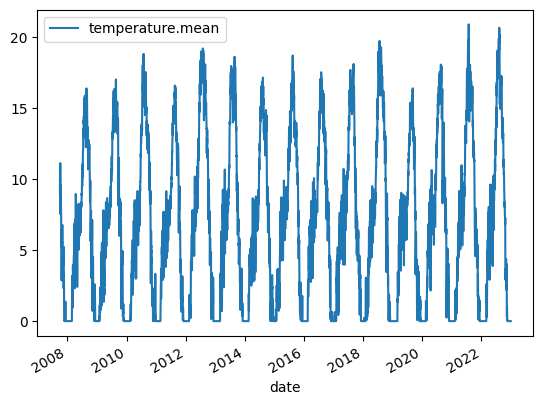

In [10]:
csd.plot.line(x="date", y="temperature.mean")

In a win for the three-sine model, the general form of the annual temperature cycle - with a clear spring-low - is quite distinct.  The question is whether that seasonal variation can be captured in a pseudophysical-statistical model or whether it requires direct approximation, TempEst 2-style.

<Axes: xlabel='tmax', ylabel='temperature.mean'>

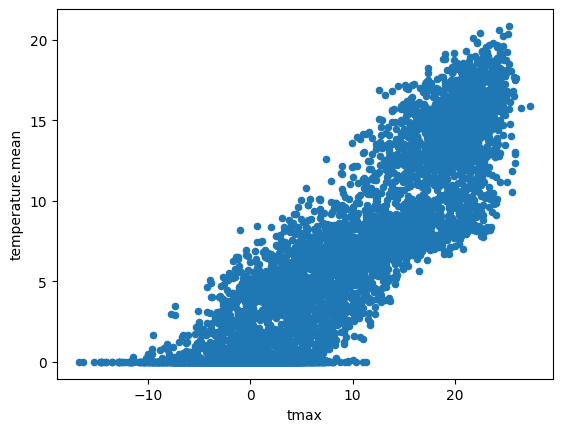

In [11]:
csd.plot.scatter(x="tmax", y="temperature.mean")

In [12]:
csd["DeltaT"] = csd["temperature.mean"].diff()
csd["DeltaAT"] = csd["tmax"].diff()

<Axes: xlabel='tmax', ylabel='DeltaT'>

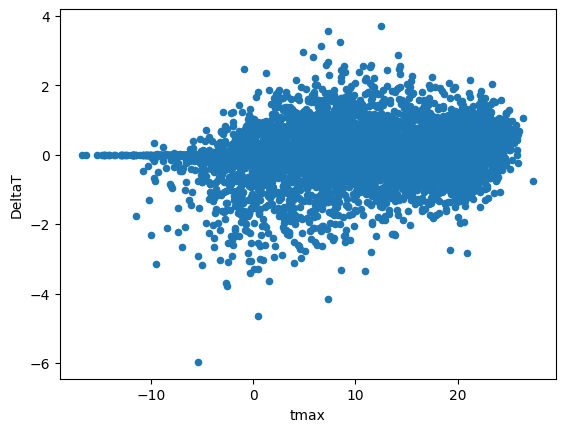

In [13]:
csd.plot.scatter(x="tmax", y="DeltaT")

<Axes: xlabel='swe', ylabel='temperature.mean'>

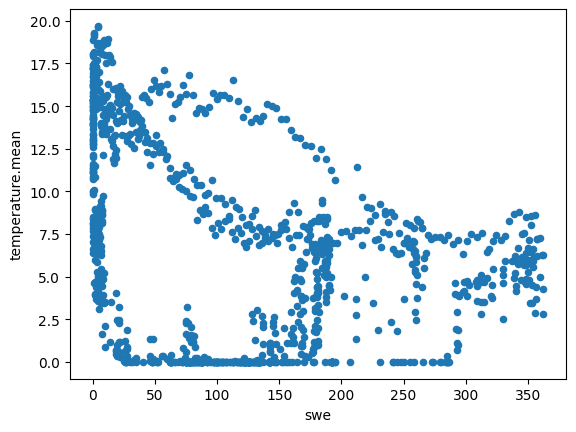

In [14]:
csd.plot.scatter(x="swe", y="temperature.mean")

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

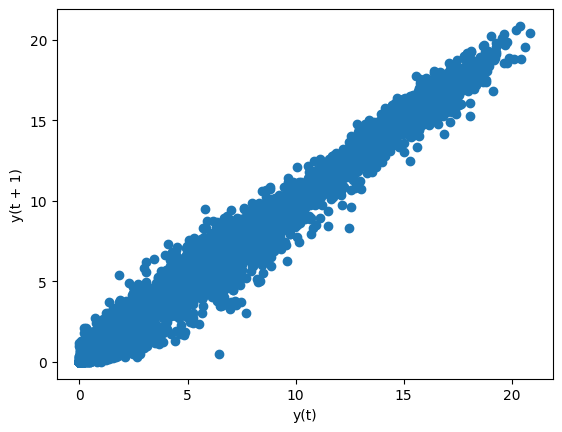

In [15]:
pdp.lag_plot(csd["temperature.mean"])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

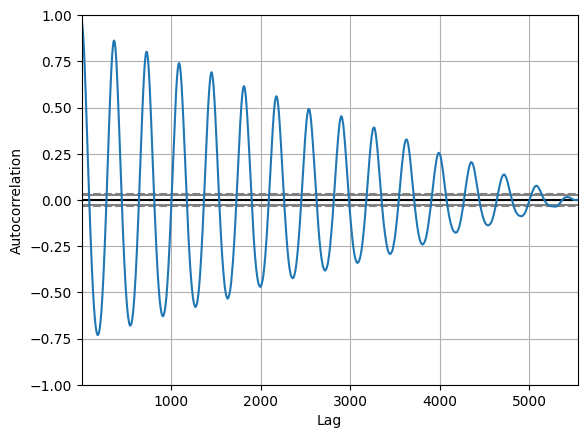

In [16]:
pdp.autocorrelation_plot(csd["temperature.mean"])

<Axes: xlabel='temperature.mean', ylabel='tmax'>

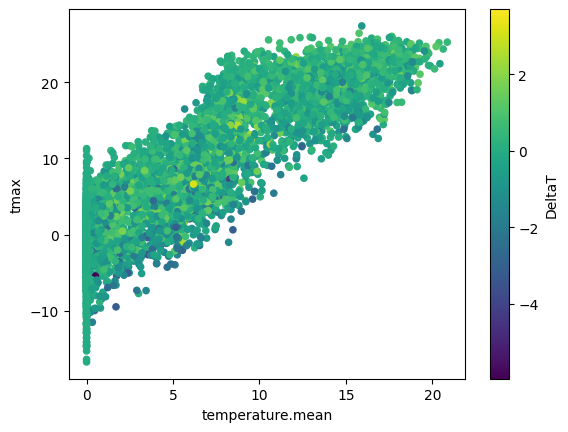

In [17]:
csd.plot.scatter(x="temperature.mean", y="tmax", c="DeltaT")

In [18]:
csd["doy"] = csd["date"].dt.day_of_year

<Axes: xlabel='doy', ylabel='DeltaT'>

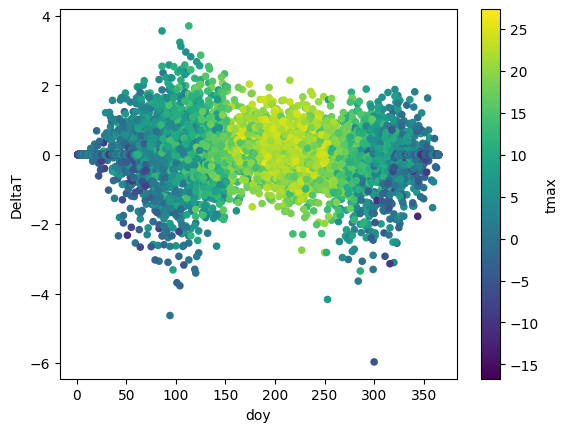

In [19]:
csd.plot.scatter(x="doy", c="tmax", y="DeltaT")

<Axes: xlabel='prcp', ylabel='DeltaT'>

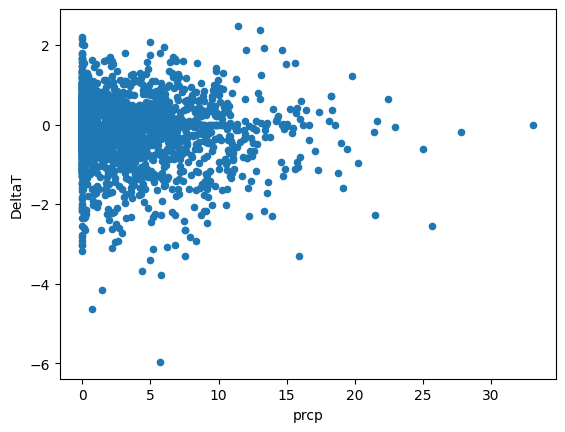

In [20]:
csd[csd["DeltaAT"] < 0].plot.scatter(x="prcp", y="DeltaT")

For Eagle River, the optimal correlation is with 18-day air temperature and mean water temperature.  Unsurprisingly, this has a sigmoidal form, but interestingly, it's actually flipped: rolling tmax appears to be a sigmoid of water temperature, not the other way around!  Now, when we color it by day-of-year, the pattern gains some clarity, and we see that the sigmoid actually reflects hysteresis driven by day-of-year norms, with the air temperature driving scatter more than the overall form.  The pattern is slightly noisier, but more obvious, using tmean (mean of minimum and maximum).

From the start of the year, water temperature increases linearly from zero to about 7-8 C while mean air temperatures increase to 0 C.  After that, the snowmelt dominates until air temperatures hit 10 C (a threshold which is probably driven by the amount of snow, not an exact number for air temperature), and water temperatures are nearly constant, with a very slight linear trend.  From air temperatures of 10-15 C (the maximum), there is a faster linear increase in water temperatures up to the maximum of about 18 C.  Then there's a steady, nearly linear (with a slight positive second derivative) decline back to 0 C, which seems to hit when air temperatures are consistently a little below freezing.

Some takeaways:

- The water is almost always *warmer* than the mean daily air temperature, presumably due to solar radiation (year-round), freezing, and groundwater (in colder months).
- Water warms up before the whole basin thaws.  Presumably, there's quite a bit of in-channel warming and warmer runoff in the lower part of the basin.
- The major snowmelt pulse fixes temperatures.  Seasonality of this could be estimated from basin characteristics, but it's worth seeing if there's a better way to do that using dynamic data.  A few thoughts:
  - Does this always happen (in snowy watersheds) at AT=0 C, or is there some other threshold?
  - Can we predict when it unsticks?  Is there a consistent snowpack or temperature threshold?
- The cooling limb of the thermograph (is there a word for that?) could be approximated quite accurately by a linear function from the maximum annual temperature down to the minimum, but we need a generic way to get the maximum and minimum coordinates.

Broadly, the seasonality is so dominant that a SCHEMA-like approach will almost certainly get the best performance, but I want to stay away from a stationary estimate of seasonality.  Instead, I should see if it's possible to dynamically identify seasonality thresholds and apply specialized regressions accordingly - assuming, of course, that this sort of pattern holds up.

                    RollAT  temperature.mean
RollAT            1.000000          0.864708
temperature.mean  0.864708          1.000000


<Axes: xlabel='RollAT', ylabel='temperature.mean'>

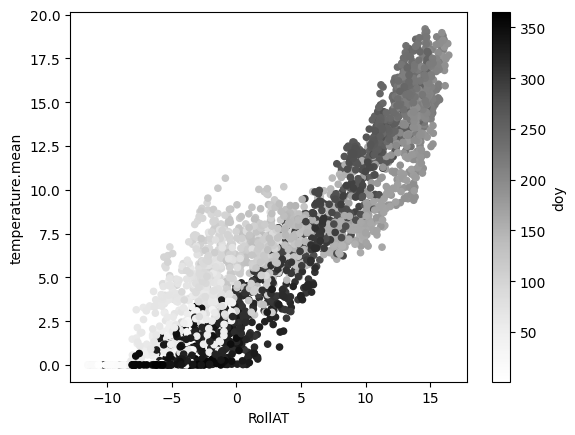

In [21]:
roll = 18  # best correlation
csd["RollAT"] = ((csd["tmax"] + csd["tmin"])/2).rolling(roll).mean()
print(csd[["RollAT", "temperature.mean"]].corr()**2)
csd.plot.scatter(x="RollAT", y="temperature.mean", c="doy")

In [95]:
csdssn = csd[["doy", "temperature.mean"]].rename(columns={"doy": "day", "temperature.mean": "temperature"})
ssn = rts.ThreeSine.from_data(csdssn.dropna()).generate_ts()
fitted = csdssn.merge(ssn, on="day")
print(fitted[["temperature", "actemp"]].corr()**2)
np.sqrt(np.mean((fitted["temperature"] - fitted["actemp"])**2))

             temperature    actemp
temperature     1.000000  0.927741
actemp          0.927741  1.000000


1.5264931554187946

<Axes: xlabel='doy', ylabel='temperature.mean'>

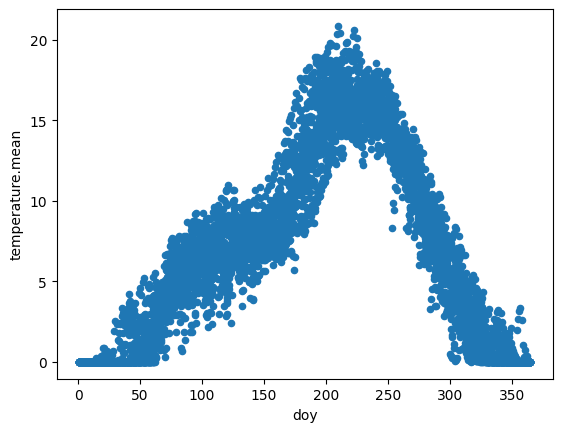

In [23]:
csd.plot.scatter(x="doy", y="temperature.mean")

Let's look at some specific years.

Overall:

- Warming started at -5 or -6 in 6/9 full-coverage years, but it could start as low as -10.
- Melt temperature was almost always 7-8 C, but some years had spikes above that and 2012 had no identifiable melt (low snow year?)
- Melt fixing began at about 0 C and ended at 8-10 C.
- Maximum water temperature was generally just slightly above maximum sustained air temperature.
- Freeze occurred between (0, 0) and (-5, 0).

In [24]:
csd["year"] = csd["date"].dt.year

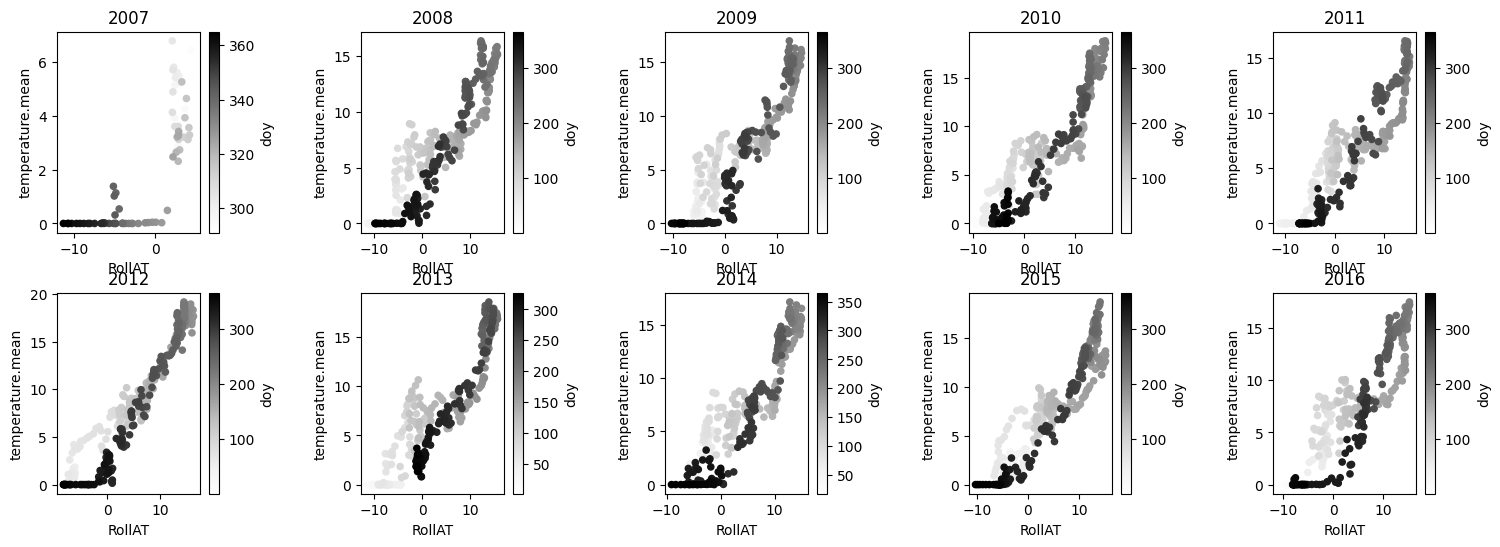

In [25]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(18,6))
plt.subplots_adjust(wspace=0.7, hspace=0.3)
for year in range(2007, 2017):
    x = (year - 2007) // 5
    y = (year - 2007) % 5
    csd[csd["year"]==year].plot.scatter(x="RollAT", y="temperature.mean", c="doy", ax=axes[x, y])
    axes[x, y].set_title(str(year))

# The Bayesian Season

## Overview

Context: stream temperature is dominated by seasonality, and I think a SCHEMA approach is pretty clearly the right conceptual framework for statistical ST modeling (that isn't full-blown ML).

However, this (specifically, SCHE; a semistatic estimate of MA would work fine) has two big shortcomings:

- It requires a lot of historical weather data, since SCHE components depend heavily on weather means
- It embeds the assumption of stationarity

So the dream would be to dynamically build a seasonal model as new weather data become available.  Does that make sense?  Well... you're basically just creating and updating a Bayesian prior!  (You could also guess a reasonably-intelligent prior from static conditions).

So what we can try doing is this:

- From static data, guess a prior for three-sine coefficients **and** some sort of air temperature seasonality (needed for MA).
- For each day of data, update both guesses and create a SCHEMA estimate.
- Some ideas for being smart about this:
	- Snowpack will drive seasonal anomaly coefficients and a lot of the timing, especially in the mountains
		- If there is major snowpack, the spring anomaly probably starts about when sustained air temperatures exceed freezing and ends when all or almost all the snow melts.  The end of the spring anomaly is the midpoint between the spring and summer anomaly peaks.
		- In the Eagle River case study, plot 3s days against SWE curve.
		- Not sure about magnitude, except that it'll increase with more snow.  Does the snowmelt energy getting sucked out of the air produce a recognizable effect on air-T where we could match magnitudes?
	- In the "cold north" regions (squished sine rather than lumpy curve), the whole thing is driven by freeze-thaw dynamics.  Can we guess from air temperature when water freezes and thaws?  Then we just need to guess the max. and it's pretty much a sine in between there.
	- In warm, low-elevation regions, we just need to guess the sine coefficients.
	- Air temperature variability probably drives a lot of the curve.  If we can define a general seasonal pattern for air temperature, we can probably compare the recent observed slope to that of a unit curve and guess the max and min (with a heavy weight towards the XYZ expectation, since that could get volatile).

## Approach

How do we try this out?

1. First, let's set a baseline: how well does a calibrated SCHEMA work? Look at $T=T_{doy}+f(weather)$.
2. Then, let's look at seasonality of weather and see if there's a usable match there.
3. Now try to guess it rolling forward for a case study (walk through it incrementally to see what's going on).
4. Finally, expand and see if we can identify a generalized approach.  Try correlating calibrated SCHEMA to long-term weather data, then see if we can work out an incremental guessing approach.

## What's the season?

From above, we know that in Eagle River the three-sine seasonality alone explains 93% of variation.  Below, it appears that it does well enough for air temperature as well, though obviously it is noisier.

In [29]:
wt_season = rts.ThreeSine.from_data(csdssn)
wt_season.to_df()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
0,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,NaN,0.574438


<Axes: xlabel='day', ylabel='temperature.mean'>

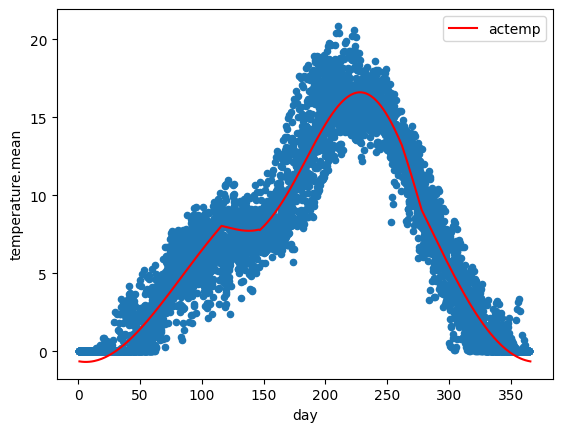

In [43]:
ax = csd.plot.scatter(x="doy", y="temperature.mean")
wt_season.generate_ts().plot.line(x="day", y="actemp", ax=ax, color="red")

In [83]:
csd["tmean"] = (csd["tmax"] + csd["tmin"])/2
at_season = rts.ThreeSine.from_data(csd[["doy", "tmean"]].rename(columns={"doy": "day", "tmean": "temperature"}))
atts = at_season.generate_ts()
at_season.to_df()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
0,3.156742,10.767704,351.0,75.0,131.0,200.0,0.796361,2.039754,NaN,1.287162


<Axes: xlabel='doy', ylabel='swe_n'>

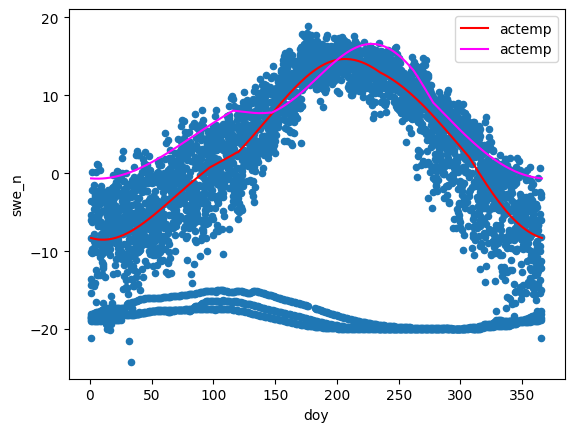

In [93]:
ax = csd.plot.scatter(x="doy", y="tmean")
atts.plot.line(x="day", y="actemp", ax=ax, color="red")
wt_season.generate_ts().plot.line(x="day", y="actemp", ax=ax, color="magenta")
csd.assign(swe_n = lambda x: x["swe"]/x["swe"].max()*5 - 20).plot.scatter(x="doy", y="swe_n", ax=ax)

We see that water temperature is generally warmer than mean air temperature, except during part of the spring snowmelt pulse - crossing points are at the end of constant water temperatures and then at maximum air temperature, after which water temperature still has some "thermal inertia".

For Eagle River, the water temperature spring-summer anomaly appears to start when SWE peaks, which makes sense.  The halfway (zero-effect) point of the spring-summer anomaly corresponds to three things: approx. zero SWE, maximum air temperature, and the peak of the air temperature summer anomaly.  I would guess that the actual driver is zero SWE.

<Axes: xlabel='day'>

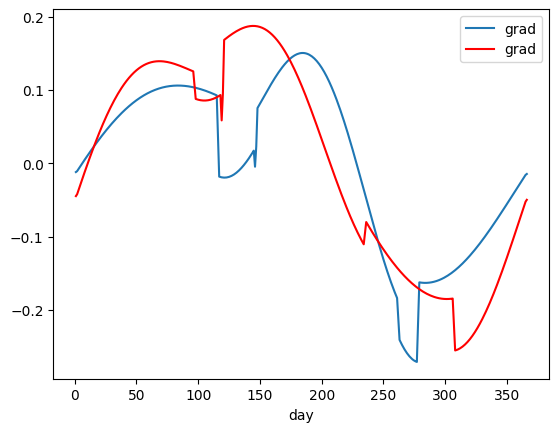

In [221]:
# Compare gradients rather than values
ax = wt_season.generate_ts().assign(grad=lambda x: np.gradient(x["actemp"])).plot(x="day", y="grad")
atts.assign(grad=lambda x: np.gradient(x["actemp"])).plot(x="day", y="grad", ax=ax, color="red")

In [53]:
fitted = csd.rename(columns={"doy": "day"}).merge(wt_season.generate_ts(), on="day").merge(atts.rename(columns={"actemp": "airssn"}), on="day")
fitted

,date,temperature.mean,prcp,srad,swe,tmax,tmin,vp,DeltaT,DeltaAT,day,RollAT,year,actemp,airssn
0,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,NaN,NaN,274,NaN,2007,10.141775,14.636594
1,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,1.131250,-5.169561,275,NaN,2007,9.872676,14.461007
2,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,-0.427083,4.765668,276,NaN,2007,9.602529,14.283946
3,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,-0.008333,2.265412,277,NaN,2007,9.331561,14.105465
4,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,1.205208,-1.063745,278,NaN,2007,9.059998,13.925616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,0.000000,1.840028,361,NaN,2022,-0.555511,-2.455855
5535,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,0.000000,-4.034827,362,NaN,2022,-0.580520,-2.526118
5536,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,0.000000,-7.892445,363,NaN,2022,-0.602905,-2.590737
5537,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,0.000000,3.265958,364,NaN,2022,-0.622671,-2.649723


          aaroll      anom
aaroll  1.000000  0.257977
anom    0.257977  1.000000


<Axes: xlabel='aaroll', ylabel='anom'>

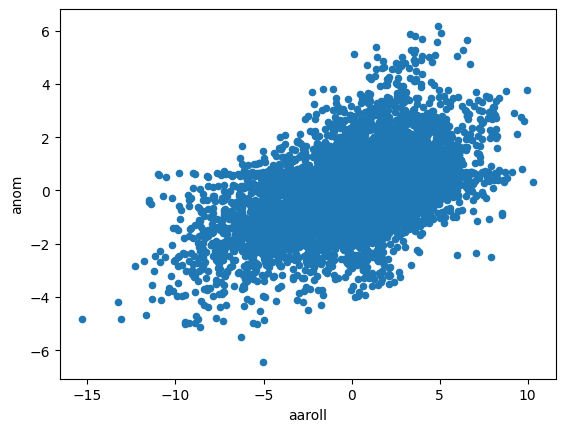

In [68]:
roll = 3  # optimal
fitted["anom"] = fitted["temperature.mean"] - fitted["actemp"]
fitted["anom_air"] = fitted["tmax"] - fitted["airssn"]
fitted["aaroll"] = fitted["anom_air"].rolling(roll).mean()
print(fitted[["aaroll", "anom"]].corr()**2)
fitted.plot.scatter(x="aaroll", y="anom")

In [76]:
fitted[["anom_air", "prcp", "swe", "anom"]].corr()

,anom_air,prcp,swe,anom
anom_air,1.000000,-0.346534,0.074282,0.414220
prcp,-0.346534,1.000000,0.094698,-0.057388
swe,0.074282,0.094698,1.000000,-0.151151
anom,0.414220,-0.057388,-0.151151,1.000000


In [97]:
tdata = csd.rename(columns={"doy": "day", "temperature.mean": "temperature"})
tdata

,date,temperature,prcp,srad,swe,tmax,tmin,vp,DeltaT,DeltaAT,day,RollAT,year,tmean
0,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,NaN,NaN,274,NaN,2007,7.056933
1,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,1.131250,-5.169561,275,NaN,2007,4.618424
2,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,-0.427083,4.765668,276,NaN,2007,6.831205
3,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,-0.008333,2.265412,277,NaN,2007,9.284183
4,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,1.205208,-1.063745,278,NaN,2007,9.805452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,0.000000,1.840028,361,NaN,2022,NaN
5535,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,0.000000,-4.034827,362,NaN,2022,NaN
5536,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,0.000000,-7.892445,363,NaN,2022,NaN
5537,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,0.000000,3.265958,364,NaN,2022,NaN


In [105]:
train = tdata[tdata["date"] < "2017-10-01"]
test = tdata[tdata["date"] >= "2017-10-01"]

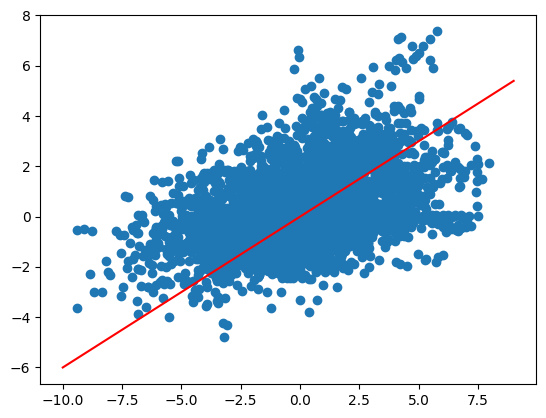

In [211]:
ssn = rts.ThreeSine.from_data(train)
wssn = train.merge(ssn.generate_ts(), on="day").merge(
    rts.ThreeSine.from_data(train[["day", "tmax"]].rename(columns={"tmax": "temperature"})).generate_ts().rename(columns={"actemp": "acair"}),
    on="day")
anom = wssn["temperature"] - wssn["actemp"]
x = (wssn["tmax"] - wssn["acair"]).rolling(7).mean()
plt.scatter(x, anom)
xt = np.arange(-10, 10)
plt.plot(xt, xt*0.6, color="red")
coef = 0.6
intercept = 0.0

In [212]:
test_prd = test.merge(ssn.generate_ts(), on="day").merge(
    rts.ThreeSine.from_data(train[["day", "tmax"]].rename(columns={"tmax": "temperature"})).generate_ts().rename(columns={"actemp": "acair"}),
    on="day").assign(modeled = lambda x: x["actemp"] + (x["tmax"] - x["acair"]).rolling(7).mean() * coef + intercept)

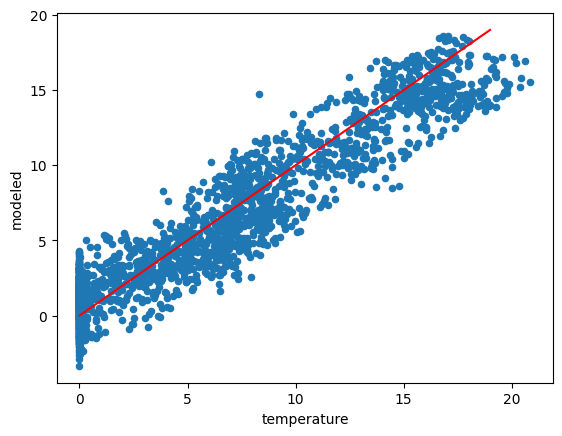

In [213]:
ax = test_prd.plot.scatter(x="temperature", y="modeled")
ax.plot(np.arange(0, 20), np.arange(0, 20), color="red")

In [215]:
test_prd[["temperature", "modeled"]].corr()**2

,temperature,modeled
temperature,1.000000,0.892314
modeled,0.892314,1.000000


In [217]:
np.sqrt(np.mean((test_prd["actemp"] - test_prd["temperature"])**2))

1.847131786568889